In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## MNISTデータセット

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
# 標準化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [4]:
# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [5]:
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
# y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
# y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# 【問題1】重みの初期値を決めるコードの作成
ニューラルネットワークの各層の重みの初期値を決めるコードを作成してください。

# 【問題2】フォワードプロパゲーションの実装
三層のニューラルネットワークの フォワードプロパゲーション を作成してください。以下の説明ではノード数は1層目は400、2層目は200としますが、変更しても構いません。

# 【問題3】交差エントロピー誤差の実装
目的関数（損失関数）を作成します。

# 【問題4】バックプロパゲーションの実装
三層のニューラルネットワークのバックプロパゲーションを作成してください。確率的勾配降下法を行う部分です。

# 【問題5】推定
推定を行うメソッドを作成してください。


フォワードプロパゲーションによって出力された10個の確率の中で、最も高いものはどれかを判定します。

In [7]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [8]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.batch_size = 20 # バッチサイズ
        self.n_features = 784 # 特徴量の数
        self.n_nodes1 = 400 # 1層目のノード数
        self.n_nodes2 = 200 # 2層目のノード数
        self.n_output = 10 # 出力のクラス数（3層目のノード数）
        self.sigma = 0.02 # ガウス分布の標準偏差
        self.lr = 0.01 #学習率
        self.epoch = 10 # エポック数
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        self.loss_train = []
        self.loss_test = []
        
        # 重みの初期値
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)

        # バイアスの初期値
        self.B1 = self.sigma * np.random.randn(1, self.n_nodes1)
        self.B2 = self.sigma * np.random.randn(1, self.n_nodes2)
        self.B3 = self.sigma * np.random.randn(1, self.n_output)
        
        for _ in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:

                #フォワードプロパゲーション
                self.forward(mini_X_train)

                # バックプロパゲーション
                self.backward(mini_X_train, mini_y_train)
            
            # 目的関数を記録
            self.forward(X)
            self.loss_train.append(self.cross_entropy_error(y, self.Z3))
            if X_val is not None:
                self.forward(X_val)
                self.loss_test.append(self.cross_entropy_error(y_val, self.Z3))

        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print(self.loss_train)
    
    def forward(self, X):
        '''
        フォワードプロパゲーションの実装
        '''
        # フォワードプロパゲーション
        # １層目
        self.A1 = X @ self.W1 + self.B1
        self.Z1 = self.tanh_function(self.A1)
        # ２層目
        self.A2 = self.Z1 @ self.W2 + self.B2
        self.Z2 = self.tanh_function(self.A2)
        # ３層目
        self.A3 = self.Z2 @ self.W3 + self.B3
        self.Z3 = self.softmax_function(self.A3)
    
    def backward(self, mini_X, mini_y):
        '''
        バックプロパゲーションの実装
        '''
        # ３層目
        dA3 = self.Z3 - mini_y
        dB3 = np.sum(dA3, axis=0)
        dW3 = self.Z2.T @ dA3
        dZ2 = dA3 @ self.W3.T
        # ２層目
        dA2 = dZ2 * (1 - self.tanh_function(self.A2)**2)
        dB2 = np.sum(dA2, axis=0)
        dW2 = self.Z1.T @ dA2
        dZ1 = dA2 @ self.W2.T
        # １層目
        dA1 = dZ1 * (1 - self.tanh_function(self.A1)**2)
        dB1 = np.sum(dA1, axis=0)
        dW1 = mini_X.T @ dA1
        # 更新
        self.W3 -= self.lr * dW3
        self.B3 -= self.lr * dB3
        self.W2 -= self.lr * dW2
        self.B2 -= self.lr * dB2
        self.W1 -= self.lr * dW1
        self.B1 -= self.lr * dB1
                
    def sigmoid_function(self, A):
        '''
        シグモイド関数
        '''
        return 1 / (1 + np.exp(-A))

    def tanh_function(self, A):
        '''
        ハイパボリックタンジェント関数
        '''
        return np.tanh(A)
    
    def softmax_function(self, A):
        '''
        ソフトマックス関数
        '''
        return np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)

    def cross_entropy_error(self, y, Z):
        '''
        交差エントロピー誤差
        '''
        L = - np.sum(y * np.log(Z)) / len(y)
        return L
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        self.forward(X)
        return np.argmax(self.Z3, axis=1)

# 【問題6】学習と推定
MNISTのデータを学習・推定し、Accuracyを計算してください。

In [9]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_val[:, np.newaxis])

In [10]:
print(X_train.shape)
print(y_train_one_hot.shape)
print(X_val.shape)
print(y_test_one_hot.shape)

(48000, 784)
(48000, 10)
(12000, 784)
(12000, 10)


In [11]:
# 学習
nn = ScratchSimpleNeuralNetrowkClassifier()
nn.fit(X_train, y_train_one_hot, X_val, y_test_one_hot)

# 推定
pred_train = nn.predict(X_train)
pred_test = nn.predict(X_val)

In [12]:
accuracy_score(y_train, pred_train)

0.9971875

In [13]:
accuracy_score(y_val, pred_test)

0.9738333333333333

# 【問題7】学習曲線のプロット
学習曲線をプロットしてください。

ニューラルネットワークは過学習が発生しやすいため、学習曲線の確認が重要です。訓練データと検証データに対するエポックごとの損失（交差エントロピー誤差）を記録できるようにする必要があります。

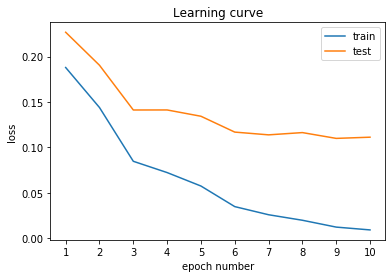

In [14]:
plt.title('Learning curve')
plt.xlabel('epoch number')
plt.ylabel('loss')
plt.plot(list(range(1, nn.epoch+1)), nn.loss_train, label='train')
plt.plot(list(range(1, nn.epoch+1)), nn.loss_test, label='test')
plt.legend()
plt.xticks(list(range(1, nn.epoch+1)));

# 【問題8】（アドバンス課題）誤分類の確認
誤分類した画像はどのようなものだったかを確認してください。推定値を用意し、以下のコードを実行してください。 

In [15]:
y_pred = pred_test

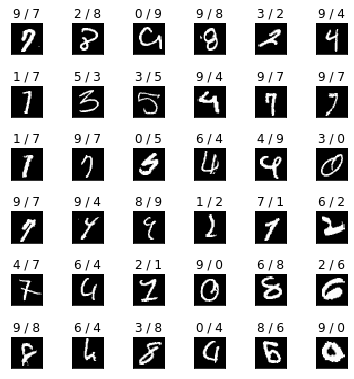

In [16]:
"""
語分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_val : 検証データの正解ラベル(n_samples,)
X_val : 検証データの特徴量（n_samples, n_features)
"""
import numpy as np
import matplotlib.pyplot as plt
num = 36 # いくつ表示するか
true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int)
if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')